<center><h1>Forecast Card</h1></center>

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq

from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

In [2]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

def obras_mes_actual(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[dataset['year_month'] ==  (fecha_ref - MonthBegin(1)).to_period('M') ]
    dataset = dataset.groupby(['year_month','Ciudad']).agg({'Obra':pd.Series.nunique}).reset_index()
    return dataset

def obras_mes_trimestre(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[(dataset['FechaEntrega'] >= fecha_ref - MonthBegin(4)) & (dataset['FechaEntrega'] < fecha_ref - MonthBegin(1))]
    dataset = dataset.groupby(['year_month','Ciudad']).agg({'Obra':pd.Series.nunique}).reset_index()
    dataset = dataset.groupby(['Ciudad']).agg({'Obra':'mean'}).reset_index()
    return dataset

def edad_vol_mes_trimestre(dataset, fecha_ref):
    #filtro los registros de este mes, teniendo en cuenta la fecha relativa actual
    dataset = dataset[(dataset['year_month'] >= fecha_ref - MonthBegin(2)) & (dataset['year_month'] < fecha_ref )]
    #dataset = dataset.groupby(['year_month','Ciudad']).agg({'Edad':'median'}).reset_index()
    dataset = dataset.groupby(['Ciudad']).agg({'Edad':'mean'}).reset_index()
    dataset['year_month'] = fecha_ref
    return dataset

In [3]:
#Variables 
pais='Colombia'
dias = 2021

In [ ]:
#Aplica solo para Colombia antes del 2019

years = [2015, 2016, 2017, 2018]
for i,var in enumerate(years):
    if i == 0:
        dataset = querySQL( "{CALL SCAC_AP10_dataset_servicios_2 (?,?)}" , (pais, var) )
        dataset = dataset.fillna(value=np.nan)
        dataset['year_month'] = dataset.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_2 (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
    dataset = pd.concat([dataset, temp ])

In [4]:
#Dataset de los despachos
#years = [2018, 2019, 2020, 2021]
years = [2021,2022]
for i,var in enumerate(years):
    if i == 0:
        df = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        df = df.fillna(value=np.nan)
        df['year_month'] = df.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
        df = pd.concat([df, temp ])

In [5]:
df = pd.concat([df, dataset])

NameError: name 'dataset' is not defined

In [5]:
#Ajuste de formatos
df['year_month'] = df['year_month'].astype(str)
df = df.sort_values(by=['year_month'])
df['year_month'] =  pd.to_datetime(df['year_month'])
df['year_month'] =  df['year_month'].dt.to_period('M')

#Volumen mensual
vol = df.groupby(['year_month','Ciudad']).agg({'VolPartida': sum}).reset_index()
vol['year_month'] = vol['year_month'].astype(str)

# Numero de obras mensuales y su relacion con la media trimestral
indicador_numero_obras = pd.DataFrame()
for i in range(len(df['year_month'].unique()) - 1):
    obras_actuales = obras_mes_actual(df, datetime.date.today() - MonthBegin(i))
    obras_trimestre = obras_mes_trimestre(df, datetime.date.today() - MonthBegin(i))
    temp = pd.merge(obras_actuales, obras_trimestre, how='left', on=['Ciudad'])
    temp['indicador_numero_obras'] = temp['Obra_x'] / temp['Obra_y']

    if i == 0:
        indicador_numero_obras = temp
    else:
        indicador_numero_obras = pd.concat([indicador_numero_obras, temp])
        
indicador_numero_obras['year_month'] = indicador_numero_obras['year_month'].astype(str)
indicador_numero_obras.rename(columns = {'Obra_x':'obras_mes', 'Obra_y':'obras_trimestre'}, inplace = True)

In [5]:
#edad del volumen
edad = querySQL( "{CALL SCAC_AP13_EdadVolumen (?,?,?)}" , (pais, '2021-01-01', '2022-09-01') )
#edad = pd.read_excel("datos/" + pais +"/" + pais +" EdadVolumen.xlsx")
edad['Fecha'] = pd.to_datetime(edad['Fecha'])
edad['Obra'] = edad['Obra'].astype(str)
edad['year_month'] = edad.Fecha.dt.to_period('M')
edad['Edad'] = pd.to_datetime(edad['Fecha']) - pd.to_datetime(edad['PrimerConsumo'])
edad['Edad'] = edad['Edad'] / np.timedelta64(1,'D')

In [7]:
analisis_edad = edad[~edad['Obra'].str.contains('F')].groupby(['year_month','Obra']).agg({'Edad':'max', 'Vol':'sum'}).reset_index()
analisis_edad['volumen_nuevo'] = analisis_edad['Vol'].where(analisis_edad['Edad'] <= 30 , 0)
pivot_temp = df.groupby(['year_month','Ciudad', 'Obra']).agg({'VolPartida': sum}).reset_index()
pivot_temp = pd.merge( pivot_temp, analisis_edad, how='left', on=(['year_month', 'Obra']) ) 
pivot_temp = pivot_temp.replace(0, np.nan)
analisis_edad = pivot_temp.groupby(['year_month','Ciudad']).agg({'Edad':'median', 'volumen_nuevo':'sum'}).reset_index()
analisis_edad['year_month'] = analisis_edad['year_month'].astype(str)
#analisis_edad


df_kpis = pd.merge(vol, indicador_numero_obras, how='left', on=['year_month', 'Ciudad'] )
df_kpis = pd.merge(df_kpis, analisis_edad, how = 'left', on=['year_month', 'Ciudad'] )
df_kpis['tasa_renovacion'] = df_kpis['volumen_nuevo'] / df_kpis['VolPartida']
df_kpis['logvolumen'] = np.log(df_kpis['VolPartida'])
#df_kpis


ciudades = df_kpis['Ciudad'].unique()

for i,var in enumerate(ciudades): 
    
    temp = df_kpis[df_kpis['Ciudad'] == var]
    temp['kpi_indicador_obra'] = temp['indicador_numero_obras'].diff()
    temp['kpi_edad'] = temp['Edad'].diff()
    temp['kpi_tasa_renovacion'] = temp['tasa_renovacion'].diff()
    temp['kpi_log_vol'] = temp['logvolumen'].diff(-1)
    
    if i == 0:
        new_kpi = temp
    else:
        new_kpi = pd.concat([new_kpi, temp])
        
new_kpi['kpi_indicador_obra_binario'] = new_kpi['kpi_indicador_obra'].apply(lambda x: 1 if x >= 0 else 0)
new_kpi['kpi_edad_binario'] = new_kpi['kpi_edad'].apply(lambda x: 1 if x >= 0 else 0)
new_kpi['kpi_tasa_renovacion_binario'] = new_kpi['kpi_tasa_renovacion'].apply(lambda x: 1 if x >= 0 else 0)
new_kpi['kpi_log_vol_binario'] = new_kpi['kpi_log_vol'].apply(lambda x: 1 if x >= 0 else 0)
#new_kpi

writer = pd.ExcelWriter("datos/" + pais + "/ConsolidadoKPIs" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
new_kpi.to_excel( writer, sheet_name="resultados" )
writer.save()

<ipython-input-7-dd1f95240f91>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['kpi_indicador_obra'] = temp['indicador_numero_obras'].diff()
<ipython-input-7-dd1f95240f91>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['kpi_edad'] = temp['Edad'].diff()
<ipython-input-7-dd1f95240f91>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<AxesSubplot:>

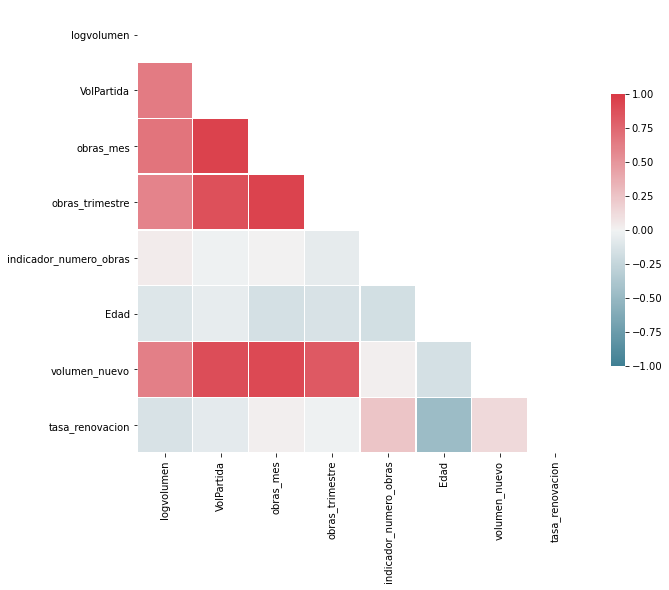

In [8]:
df_corr = df_kpis#[df_kpis['Ciudad']=='Bucaramanga']
df_corr = df_corr[['logvolumen', 'VolPartida', 'obras_mes', 'obras_trimestre', 'indicador_numero_obras','Edad', 'volumen_nuevo', 'tasa_renovacion']].corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, vmax=1, vmin=-1, cmap=cmap, center=0, square=True, linewidth=.5, cbar_kws={"shrink":.5} )

<ipython-input-78-96b0934dee1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['kpi_indicador_obra'] = temp['indicador_numero_obras'].diff()
<ipython-input-78-96b0934dee1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['kpi_edad'] = temp['Edad'].diff()
<ipython-input-78-96b0934dee1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,year_month,Ciudad,VolPartida,obras_mes,obras_trimestre,indicador_numero_obras,Edad,volumen_nuevo,tasa_renovacion,logvolumen,kpi_indicador_obra,kpi_edad,kpi_tasa_renovacion,kpi_log_vol,kpi_indicador_obra_binario,kpi_edad_binario,kpi_tasa_renovacion_binario,kpi_log_vol_binario
0,2018-01,Ponce,1662.907125,NaN,NaN,NaN,0.0,474.024100,0.285057,7.416323,NaN,NaN,NaN,0.000460,0,0,0,1
2,2018-02,Ponce,1662.142570,53.0,61.000000,0.868852,0.0,900.645790,0.541858,7.415863,NaN,0.0,0.256801,0.336380,0,1,1,1
4,2018-03,Ponce,1187.353915,62.0,57.000000,1.087719,0.0,632.286985,0.532518,7.079483,0.218867,0.0,-0.009341,0.012310,1,1,0,1
6,2018-04,Ponce,1172.827370,48.0,58.666667,0.818182,1.0,636.874315,0.543025,7.067173,-0.269537,1.0,0.010507,-0.194309,0,1,1,0
8,2018-05,Ponce,1424.365965,75.0,54.333333,1.380368,0.0,561.183370,0.393988,7.261482,0.562186,-1.0,-0.149037,-0.101003,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2020-12,Puerto Rico,2819.296563,117.0,118.666667,0.985955,165.5,538.246720,0.190915,7.944243,0.200770,3.5,0.084718,0.121536,1,1,1,1
72,2021-01,Puerto Rico,2496.654352,110.0,113.000000,0.973451,140.0,618.142717,0.247588,7.822707,-0.012504,-25.5,0.056673,0.235042,0,0,1,1
74,2021-02,Puerto Rico,1973.698732,106.0,111.000000,0.954955,185.0,411.712868,0.208600,7.587665,-0.018496,45.0,-0.038989,-0.243884,0,1,0,0
76,2021-03,Puerto Rico,2518.826447,96.0,111.000000,0.864865,685.5,536.717610,0.213082,7.831548,-0.090090,500.5,0.004483,1.025470,0,1,1,1


In [9]:
writer = pd.ExcelWriter("datos/" + pais + "/ConsolidadoKPIs" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
new_kpi.to_excel( writer, sheet_name="resultados" )
writer.save()

In [9]:
#cargar datos de archivo de excel
new_kpi =  pd.read_excel("datos/" + pais +"/ConsolidadoKPIs.xlsx")

In [10]:
def probabilidad_tendencia_volumen(dff, year_month_target, ciudad_target):
    
    target = dff[(dff['year_month'] == year_month_target) & (dff['Ciudad'] == ciudad_target)]
    dff_escenario_equivalentes = dff[
        (dff['obras_mes'].notnull() ) & 
        (dff['year_month'] != year_month_target) & 
        (dff['Ciudad'] == ciudad_target) & 
        (dff['kpi_indicador_obra_binario'] == target.iloc[0]['kpi_indicador_obra_binario'] ) & 
        (dff['kpi_edad_binario'] == target.iloc[0]['kpi_edad_binario'] ) & 
        (dff['kpi_tasa_renovacion_binario'] == target.iloc[0]['kpi_tasa_renovacion_binario']) ]
    return dff_escenario_equivalentes

In [15]:
month_target = '2021-06'
ciudades = df_kpis[df_kpis['year_month'] == month_target]['Ciudad'].unique()
r = []
for i, var in enumerate(ciudades):
    t = probabilidad_tendencia_volumen(new_kpi, month_target, var)
    r.append(t['kpi_log_vol_binario'].sum()/t['kpi_log_vol_binario'].count())
    
df_r = pd.DataFrame({'Ciudad': ciudades,
                  'probabilidad_alza_volumen': r})
df_r

<ipython-input-15-f2d308dbb6e8>:6: RuntimeWarning: invalid value encountered in longlong_scalars
  r.append(t['kpi_log_vol_binario'].sum()/t['kpi_log_vol_binario'].count())


,Ciudad,probabilidad_alza_volumen
0,Barranquilla,0.333333
1,Bogotá,0.692308
2,Bucaramanga,0.538462
3,Cali,0.450000
4,Cartagena,0.466667
5,Cúcuta,0.347826
6,Ibagué,0.300000
7,Medellín,0.375000
8,Neiva,0.700000
9,PAMPLONA,NaN


In [358]:
writer = pd.ExcelWriter("datos/" + pais + "/Probabilidad-" + month_target + "_" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_r.to_excel( writer, sheet_name="resultados" )
writer.save()

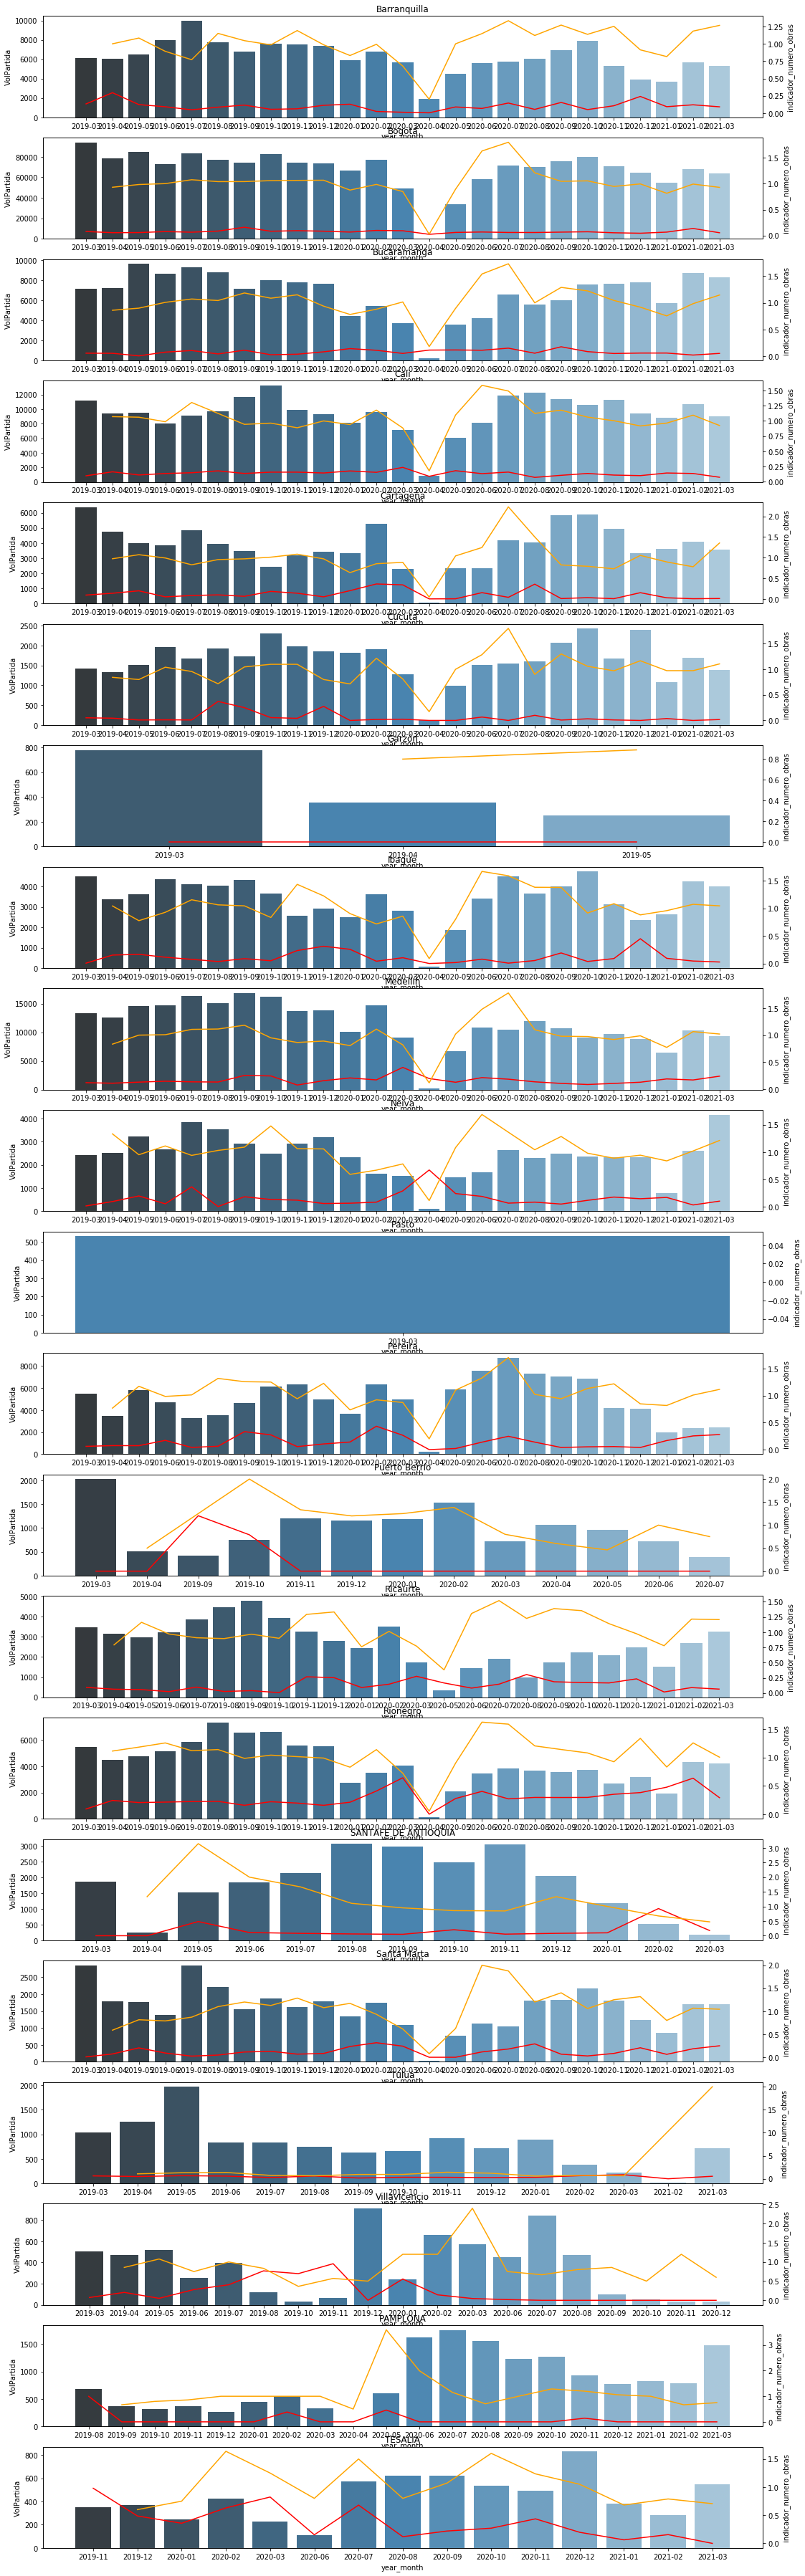

In [210]:
ciudades = df_kpis['Ciudad'].unique()
fig, ax= plt.subplots(len(ciudades), 1, figsize=(18,65))
#plt.figure(figsize=(18,50))
for i,var in enumerate(ciudades):
    #plt.subplot(len(ciudades),2, i+1)
    sns.barplot(x= 'year_month', y = 'VolPartida', data= df_kpis[df_kpis['Ciudad'] == var], ci =None, ax = ax[i], palette='Blues_d')
    #sns.lineplot(x= 'year_month', y = 'volumen_nuevo', data= df_kpis[df_kpis['Ciudad'] == var], ci =None, ax = ax[i], color='blue')

    ax2 = ax[i].twinx()
    #sns.lineplot(x= 'year_month', y = 'edad_trimestre', data= df_kpis[df_kpis['Ciudad'] == var], ci =None, ax = ax2, color='red')
    sns.lineplot(x= 'year_month', y = 'tasa_renovacion', data= df_kpis[df_kpis['Ciudad'] == var], ci =None, ax = ax2, color='red')
    sns.lineplot(x= 'year_month', y = 'indicador_numero_obras', data= df_kpis[df_kpis['Ciudad'] == var], ci =None, ax = ax2, color='orange')

    plt.title(var)

In [229]:
#edad trimestre del volumen
"""
analisis_edad['year_month'] = pd.to_datetime(analisis_edad['year_month'])
edad_trimestre = pd.DataFrame()
for i in range(24):
    
    if i == 0:
        edad_trimestre = edad_vol_mes_trimestre(analisis_edad, datetime.date.today() - MonthBegin(i+1) )
    else:
        edad_trimestre = pd.concat([edad_trimestre, edad_vol_mes_trimestre(analisis_edad, datetime.date.today() - MonthBegin(i+1) )])
edad_trimestre.rename(columns={'Edad':'edad_trimestre'}, inplace=True)

analisis_edad['year_month'] = analisis_edad['year_month'].dt.to_period('M')
edad_trimestre['year_month'] = edad_trimestre['year_month'].dt.to_period('M')

analisis_edad['year_month'] = analisis_edad['year_month'].astype(str)    
edad_trimestre['year_month'] = edad_trimestre['year_month'].astype(str) 
"""

In [6]:
df.head()

,Pedido,servicio,Entrega,Estatus,EstatusPedido,Cluster,Planta,TipoPlanta,Ciudad,Centro,...,TiempoAlistamiento,TiempoIda,TiempoObra,TiempoRegreso,VolEntregado,CancelacionCliente,CancelacionCemex,CancelacionOtros,TipoObra,year_month
0,8010829224,L001,190211873,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,117.0,4.0,60.0,NaN,7.0,NaN,NaN,NaN,Normal,2021-02
1,8010829224,L002,190211880,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,9.0,51.0,103.0,42.0,7.0,NaN,NaN,NaN,Normal,2021-02
2,8010829224,L003,190212815,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,26.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,Normal,2021-02
3,8010829224,L004,190213437,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,10.0,41.0,14.0,157.0,7.0,NaN,NaN,NaN,Normal,2021-02
4,8010851670,L008,190247082,Normal,En proceso - Cabecera,CLUSTER CENTRO,CO-PLANTA Canoas,CXO,Bogotá,FB84,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2021-02


In [11]:
edad[['Obra', 'PrimerConsumo']].drop_duplicates()

,Obra,PrimerConsumo
0,66896625,2020-09-24
1,F061,2013-06-12
2,66400003,2017-04-28
3,FB40,2016-06-11
4,66486172,2017-12-28
...,...,...
71117,67047384,2022-03-14
71125,67036866,2022-03-14
71126,67044861,2022-03-14
71127,67045942,2022-03-14


In [6]:
df1 = pd.merge(df, edad[['Obra', 'PrimerConsumo']].drop_duplicates(), on=['Obra'] )
df1.head().T

,0,1,2,3,4
Pedido,8010829224,8010829224,8010829224,8010829224,8011120174
servicio,L001,L002,L003,L004,L001
Entrega,190211873,190211880,190212815,190213437,193532912
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera
Cluster,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE
Planta,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Cali,Cali,Cali,Cali,Cali
Centro,F010,F010,F010,F010,F010


In [7]:
df1['year_month_primerconsumo'] = df1.PrimerConsumo.dt.to_period('M')

In [8]:
df2 = df1[df1['year_month'] == df1['year_month_primerconsumo']][['Obra', 'year_month']].drop_duplicates()
df1[df1['year_month'] == df1['year_month_primerconsumo']].groupby(['year_month'])['year_month_primerconsumo'].count().reset_index()

,year_month,year_month_primerconsumo
0,2021-01,1123
1,2021-02,1640
2,2021-03,1342
3,2021-04,1322
4,2021-05,1248
5,2021-06,1445
6,2021-07,1370
7,2021-08,1337
8,2021-09,1113
9,2021-10,1318


In [9]:
df2 = df1[df1['year_month'] == df1['year_month_primerconsumo']][['Obra', 'year_month']].drop_duplicates()
df2

,Obra,year_month
1460,66927966,2021-01
2702,66932527,2021-02
5513,66924607,2021-01
5612,66928436,2021-01
6949,66929418,2021-01
...,...,...
270812,67034981,2022-01
270813,67041364,2022-02
270814,67040904,2022-02
270815,67038390,2022-02


In [11]:
df2.groupby(['year_month'])['Obra'].count().reset_index()

,year_month,Obra
0,2021-01,168
1,2021-02,233
2,2021-03,205
3,2021-04,163
4,2021-05,155
5,2021-06,169
6,2021-07,184
7,2021-08,185
8,2021-09,188
9,2021-10,196
